# 1. Introduction to PyTorch
## 1.4 Datasets & Dataloaders

### Loading a Dataset 

__FashionMNIST__ paramater

- `root` is the path where the train/test data is stored,
- `train` specifies training or test dataset,
- `download=True` downloads the data from the internet if it’s not available at root.
- `transform` and `target_transform` specify the feature and label transformations

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Iterating and Visualizing the Dataset 

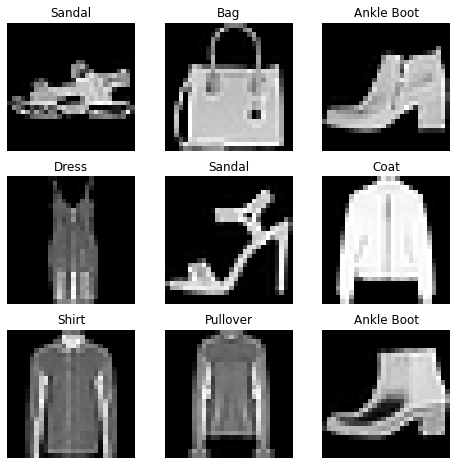

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files 

custome Dataset class 는  __ __init__ __, __ __len__ __, and __ __getitem__ __ 함수를 implement해야한다. 
FasionMNIST image들은 `img_dir`에 저장되고, label은 `annotations_file` CSV 파일에 저장된다.

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

* __ init __ 
  * Dataset object를 초기화할 때 한번 실행 
  * Initialize the directory containing the images, the annotations file, and both transforms
  
* __ len __ 
  * returns the number of samples in our dataset 

* __ getitem __ 
  * loads and returns samples from the dataset at the given index `idx`. 
  * Convert images to a tensor using `read_image` 
  * retreives the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them, 
  * returns the tensor image and corresponding label in a tuple. 
  


### Preparing your data for training with DataLoaders 

* `Dataset` retreives our dataset's features and labels onw sample at a time. 
* model을 train하면서 일반적으로 sample을 minibatches로 보내고, *model overfitting을 줄이기 위해* 각 epoch마다 data를 __reshuffle__ 하고, data retrieval의 속도를 높이기 위해 Python의 `multiprocessing`을 사용한다. 

* `DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader 

* dataset을 `DataLoader`로 load 하고 필요한 만큼 dataset을 iterate할 수 있다. 
* `shuffle=True` => After we iterate over all batches, the data is shuffled. 


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


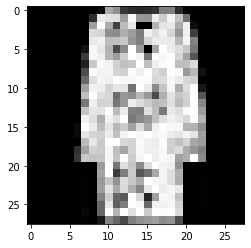

Label: 3


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))  ## 
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()  ## .squeeze(): 1차원인 것을 없애주는. dimension을 맞춰주는 함수
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


-----

## 1.5 Transforms 

* Data가 항상 machine learning algorithm을 학습하기 위해 필요한 형태로 가공되어서 오지는 않는다. 데이터를 손질하고 학습하기에 적합하게 만들기 위해서 __transforms__ 를 사용한다. 

* 모든 TorchVision dataset은 두 parameter를 가지고 있는데 
  - `transform`: modify the features 
  - `target_transform`: modify the labels (that accept callables containing the transformation logic)

* FashionMNIST __feature__ 는 PIL image format 이고 __label__ 은 integer 이다. 학습을 하기 위해서는 __feature__ 는 normalized tensor로, __label__ 은 one-hot encoded tensor로 가져야 한다. 이렇게 변형하기 위해서 `ToTensor`와 `Lambda` 를 사용한다. 


In [11]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### ToTenser() 

ToTensor converts a PIL images or NumPy `ndarray` into a `FloatTensor` and scales the image's pixel intensity values in the range [0., 1.]. 

### Lambda Transforms 

Lambda transforms apply any __user-defined lambda function__. Here we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (num of labels in dataset) and calls scatter_ which assigns a `value=1` on the index as given by the label `y`. 

In [12]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))


----

## 1.6 Build the neural network 

Neural networks comprise of layers/modules that perform operations on data. 
나만의 neural network를 build 하기 위한 building block을 __torch.nn__ namespace가 제공한다. 
Pytorch에 모든 모듈은 __nn.Module__ 의 subclass 이다. neural network는 서로 다른 layer들로 구성된 모듈 자체이다. 이 nested structure는 복잡한 구조를 만들고 다루기 쉽게 만들어준다. 

이 다음부터 FashionMNIST dataset을 구분하기 위한 neural network를 만드는 예제 코드이다! 


In [14]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Get Device for Traning 

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Define the Class 
`nn.Module` 을 상속해서 neural network를 정의하고 neural network의 layer들을 __ init __ 함수에서 초기화한다. 모든 `nn.Module` subclass는 input data에 forward 방식으로 동작한다. 

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


모델을 사용하기 위해 input data를 넣어주면 된다. 

This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [30]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([9])


### Model Layers 

example of break down the layers in the FashionMNIST model 

=> take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network. 


In [31]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten 

initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values. 


In [32]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear 
a module that applies a linear transformation on the input using its stored weights and biases. 


In [33]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU 

Non-linear activations create the complex mappings between model's input and output. They are applied after linear transformations helping neural networks lean a wide variety of phenomena. 

nn.ReLU() 도 있고, 다른 다양한 activation function들이 있다. 


In [34]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.0013,  0.2905,  0.4191, -0.1190,  0.3992, -0.2269,  0.1279, -0.0589,
          0.0980, -0.6352, -0.0183,  0.0165, -0.1881,  0.4421,  0.4176, -0.2095,
         -0.3602,  0.2165,  0.1295,  0.2766],
        [-0.2128,  0.2400,  0.0130,  0.2664,  0.5669, -0.3406,  0.0659, -0.0899,
         -0.3555, -0.2634,  0.1361,  0.0443,  0.0464, -0.0833,  0.5421, -0.1198,
         -0.2386,  0.1615, -0.3461,  0.0414],
        [-0.3102,  0.3113,  0.2228,  0.1433,  0.3480, -0.1680, -0.1957, -0.2883,
         -0.2974, -0.2863,  0.3463, -0.1159,  0.2501, -0.0939,  0.3460, -0.2407,
         -0.1515,  0.1285, -0.2155,  0.0087]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0013, 0.2905, 0.4191, 0.0000, 0.3992, 0.0000, 0.1279, 0.0000, 0.0980,
         0.0000, 0.0000, 0.0165, 0.0000, 0.4421, 0.4176, 0.0000, 0.0000, 0.2165,
         0.1295, 0.2766],
        [0.0000, 0.2400, 0.0130, 0.2664, 0.5669, 0.0000, 0.0659, 0.0000, 0.0000,
         0.0000, 0.1361, 0.0443, 0.0464, 0.0000, 0.54

### nn.Sequential 

__nn.Sequential__ is an ordered container of modules. Data is passed through all the modules in the same order as defined. 

You can use sequential containders to put together a quick network like `seq_modules`.



In [35]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax 

neural netowkr의 마지막 linear layer는 nn.Softmax module로 전달되는 logits 을 return 한다. logits은 각 class에 대한 예측 확률을 나타내는 [0, 1] 값으로 나타내야 한다. `dim` parameter는 dimension을 나타내는 것으로 값들을 다 합치면 1이 되어야 한다. 

In [36]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

### Model Parameters 

neural network 안에 많은 layer들은 training 하면서 최적화된 weight와 bias로 parameterized 되어있다. `nn.Module`은 model object 안에 정의된 모든 field 를 자동으로 track하고, 모든 parameter는 model의 `parameters()`와 `named_parameters()` method로 access할 수 있다. 

In [37]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0062, -0.0117, -0.0147,  ...,  0.0173,  0.0316,  0.0066],
        [-0.0334, -0.0256, -0.0225,  ..., -0.0158,  0.0234,  0.0324]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0244, -0.0227], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0205, -0.0370,  0.0101,  ..., -0.0244,  0.0289, -0.0210],
        [ 0.0440,  0.0329, -0.0084,  ...,  0.0017,  0.0287, -0.0414]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 